In [1]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive




### Import library 

In [35]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     


from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler 

from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler 
# import plotly.graph_objects as go


# from sklearn.ensemble import IsolationForest  

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed   


     

In [36]:
# import data set from the local driver 
df=pd.read_csv('drive/My Drive/Colab Notebooks/SWaT_Dataset_Attack_v0 - Copy.csv') # ,parse_dates = ['Timestamp'], index_col = 'Timestamp')
df.head()  

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal


#### Data preprocessing 
- Treatment the missing values 
- Feature  Scaling 
- one hot encoding :
 

In [37]:
# checking the missing values, so there is not missing values 
df['Normal/Attack'] = df['Normal/Attack'].str.replace(' ', '')  
df.isnull().sum().head() 

Timestamp    0
FIT101       0
LIT101       0
MV101        0
P101         0
dtype: int64

In [38]:
# catagorize the columns to sensor and actuators 
sensor_columns = df[['FIT101','LIT101','AIT201','AIT202','AIT203','FIT201','DPIT301','FIT301','LIT301','AIT401','AIT402','FIT401','LIT401','AIT501','AIT502','AIT503','AIT504','FIT501','FIT502','FIT503','FIT504','PIT501','PIT502','PIT503','FIT601']]
actuator_columns = df[['MV101','P101','P102', 'MV201', 'P201', 'P202','P203', 'P204','P205','P206','MV301','MV302','MV303','MV304','P301','P302','P401','P402','P403','P404','UV401','P501','P502','P601','P602','P603']]
sensor_columns.shape ,actuator_columns.shape 

((449919, 25), (449919, 26))

### Features removed in feature filtering 
- Variance equals 0 
- K-S Statistic higher than 0.25 
- Training and test empirical distributions do
not match 

In [39]:
# drop feature for actuator columns  
# drop the P202, P301, P401, P404, P502, P601 since variance = 0 and 
# drop P201 since the Training and test empirical distributions do not match 
actuator_columns=actuator_columns.drop(['P202','P201', 'P301','P401','P404','P502','P601'], axis=1)   
# drop the following features where K-S Statistic higher than 0.25  it is  drop the sensor cols  
sensor_columns=sensor_columns.drop(['AIT402', 'AIT201', 'AIT501', 'AIT502', 'AIT202', 'AIT504', 'FIT301',
                     'AIT203', 'AIT401', 'AIT503', 'FIT601','PIT502','PIT503','PIT501'], axis=1)    

In [40]:
# fetch the dimensions of sensor and  actuator columns  
actuator_columns.shape, sensor_columns.shape
# scale the sensor data using standard scaler 
from sklearn.preprocessing import StandardScaler  
object= StandardScaler()  
# standardization 
scale = object.fit_transform(sensor_columns) 
print(scale)   

# converting array to dataframe 
sensor_columns_scale = pd.DataFrame(scale)   
sensor_columns_scale.shape  

[[ 0.59805461 -0.67175852  0.65690477 ...  0.25351421  0.2940298
   0.29632566]
 [ 0.61418011 -0.67144488  0.65690477 ...  0.30753449  0.2940298
   0.29632566]
 [ 0.65019292 -0.67175852  0.65418419 ...  0.29672923  0.2940298
   0.30661561]
 ...
 [ 0.68566786 -0.68898798  0.66994407 ...  0.22303236  0.29200291
   0.2812868 ]
 [ 0.67706764 -0.68867434  0.66994407 ...  0.20605481  0.29200291
   0.29870074]
 [ 0.66067362 -0.68554193  0.66824271 ...  0.23267787  0.29200291
   0.30265756]]


(449919, 11)

In [41]:
## Apply one hot encoding for actuator data 
one_hot_encoded_data = pd.get_dummies(actuator_columns, columns = ['MV101','P101','P102', 'MV201','P203', 'P204','P205','P206','MV301','MV302',
                                                                   'MV303','MV304','P302','P402','P403','UV401','P501','P602','P603']) 
one_hot_encoded_data.head() 

# Concatinate the sensor and actuator columns using one hot encoding and StandardScaler
df_concat = pd.concat([df['Timestamp'],sensor_columns_scale, one_hot_encoded_data,df['Normal/Attack']], axis=1)   
df_concat.head()      

,Timestamp,0,1,2,3,4,5,6,7,8,...,P403_1,P403_2,UV401_1,UV401_2,P501_1,P501_2,P602_1,P602_2,P603_1,Normal/Attack
0,28/12/2015 10:00:00 AM,0.598055,-0.671759,0.656905,0.506541,0.572369,0.274596,0.583244,0.271600,0.253514,...,1,0,0,1,0,1,1,0,1,Normal
1,28/12/2015 10:00:01 AM,0.614180,-0.671445,0.656905,0.506541,0.572369,0.280018,0.583037,0.271600,0.307534,...,1,0,0,1,0,1,1,0,1,Normal
2,28/12/2015 10:00:02 AM,0.650193,-0.671759,0.654184,0.499097,0.576348,0.280018,0.582211,0.270734,0.296729,...,1,0,0,1,0,1,1,0,1,Normal
3,28/12/2015 10:00:03 AM,0.688087,-0.670818,0.654184,0.499097,0.580329,0.277163,0.581797,0.270734,0.258144,...,1,0,0,1,0,1,1,0,1,Normal
4,28/12/2015 10:00:04 AM,0.717381,-0.666746,0.654865,0.499097,0.583811,0.277163,0.584071,0.270734,0.258144,...,1,0,0,1,0,1,1,0,1,Normal


In [42]:
# Rename the col name Normal/Attack with label 
df_concat.rename(columns = {'Normal/Attack':'label'}, inplace = True) 
# Convert non-numeric class to numeric - lable encode the class using 0 (Normal) and 1(Attack)  

df_concat.label[df_concat.label== 'Normal'] = 0  
df_concat.label[df_concat.label == 'Attack'] = 1    
df_concat.head(2)   

<ipython-input-42-9f3575aa47bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat.label[df_concat.label== 'Normal'] = 0
<ipython-input-42-9f3575aa47bb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat.label[df_concat.label == 'Attack'] = 1


,Timestamp,0,1,2,3,4,5,6,7,8,...,P403_1,P403_2,UV401_1,UV401_2,P501_1,P501_2,P602_1,P602_2,P603_1,label
0,28/12/2015 10:00:00 AM,0.598055,-0.671759,0.656905,0.506541,0.572369,0.274596,0.583244,0.2716,0.253514,...,1,0,0,1,0,1,1,0,1,0
1,28/12/2015 10:00:01 AM,0.614180,-0.671445,0.656905,0.506541,0.572369,0.280018,0.583037,0.2716,0.307534,...,1,0,0,1,0,1,1,0,1,0


In [43]:
# Convert a Timestamp column to datetime   
df_concat['Timestamp'] = pd.to_datetime(df_concat['Timestamp'])    
# set the DataFrame index using A Timestamp 
df_concat= df_concat.set_index('Timestamp') 
df_concat.head()   

# retaking a sample from the all 
df_concat_sample=df_concat.sample(frac=0.3, replace=True, random_state=48)  

### Find the correlated features 

In [44]:
df_concat_sample.shape

(134976, 55)

#### Split the dataset into train and test data 

In [45]:
# split the normal data with respect to test and Train 
from sklearn.model_selection import train_test_split  
train_size = int(len(df_concat_sample)*0.8)
train_dataset, test_dataset = df_concat_sample.iloc[:train_size],df_concat_sample.iloc[train_size:]  
train_dataset.shape, test_dataset.shape 

((107980, 55), (26996, 55))

#### Split the target variable and dependent variables  

In [46]:
# Split train data to X and y
X_train = train_dataset.drop('label', axis = 1)
y_train = train_dataset.loc[:,['label']]
# Split test data to X and y
X_test = test_dataset.drop('label', axis = 1)
y_test = test_dataset.loc[:,['label']] 

y_test.shape  
# to fetch the dimensions of train and test 
X_train.shape,y_train.shape, X_test.shape, y_test.shape  

# ## converting data frame to numpy  
train_x_norm= X_train.to_numpy()  
train_y_norm=y_train.to_numpy()
test_x_norm=X_test.to_numpy()
test_y_norm=y_test.to_numpy()   

####  Create a 3D input dataset 

In [47]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 10 
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape) 

X_train.shape:  (26986, 10, 54)
y_train.shape:  (107970, 1)
X_test.shape:  (26986, 10, 54)
y_test.shape:  (107970, 1)


#### Create LSTM model  

In [48]:
# # Create LSTM model
def create_model(units, m):
    # The LSTM architecture  
    model = Sequential()
     # First LSTM layer with Dropout regularisation  
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Second LSTM layer 
    model.add(m (units = units))
    model.add(Dropout(0.2)) 
    # The output layer 
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', metrics=['accuracy'],optimizer='adam')
    return model   

 


In [49]:
#LSTM 
model_lstm = create_model(512, LSTM) 
print(model_lstm.summary())  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 512)           1161216   
                                                                 
 dropout_2 (Dropout)         (None, 10, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,260,929
Trainable params: 3,260,929
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
# convert a Numpy array to a Tensor 
X_train = np.asarray(X_train).astype(np.int64)
y_train = np.asarray(y_train).astype(np.int64)  

In [51]:
# Fit the models 
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop]) 
    return history 
    print('Test loss:', score[0])  
    print('Accuracy:', score[1]) 

history_lstm = fit_model(model_lstm)    

Epoch 1/10
2700/2700 [==============================] - 832s 306ms/step - loss: 0.1101 - accuracy: 0.8779 - val_loss: 0.1050 - val_accuracy: 0.8809
Epoch 2/10
2700/2700 [==============================] - 822s 304ms/step - loss: 0.1072 - accuracy: 0.8785 - val_loss: 0.1050 - val_accuracy: 0.8809
Epoch 3/10
2700/2700 [==============================] - 808s 299ms/step - loss: 0.1070 - accuracy: 0.8785 - val_loss: 0.1050 - val_accuracy: 0.8809
Epoch 4/10
2700/2700 [==============================] - 821s 304ms/step - loss: 0.1069 - accuracy: 0.8785 - val_loss: 0.1050 - val_accuracy: 0.8809
Epoch 5/10
2700/2700 [==============================] - 810s 300ms/step - loss: 0.1068 - accuracy: 0.8785 - val_loss: 0.1050 - val_accuracy: 0.8809
Epoch 6/10
2700/2700 [==============================] - 825s 305ms/step - loss: 0.1068 - accuracy: 0.8785 - val_loss: 0.1050 - val_accuracy: 0.8809
Epoch 7/10
2700/2700 [==============================] - 822s 304ms/step - loss: 0.1068 - accuracy: 0.8785 - val_

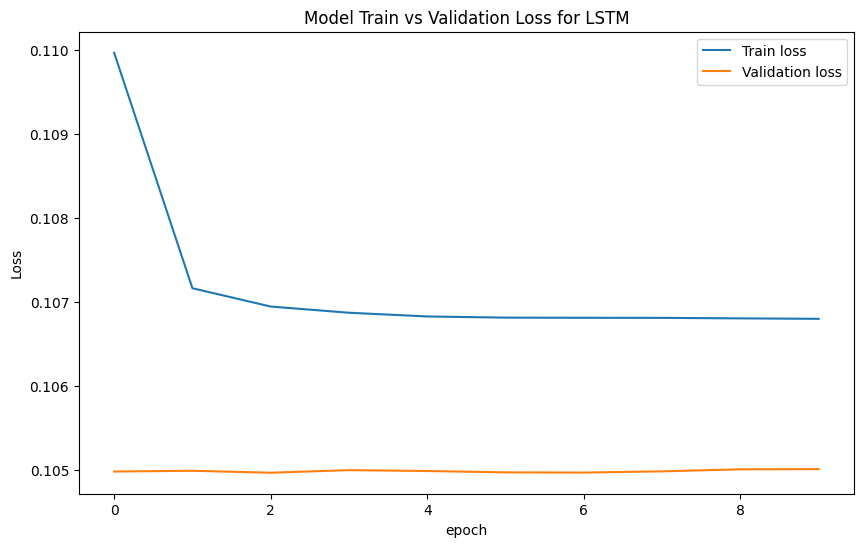

In [20]:
# Plot train loss and validation loss 
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    


plot_loss (history_lstm, 'LSTM')
 

In [52]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    #prediction = scaler_y.inverse_transform(prediction)
    return prediction 

prediction_lstm = prediction(model_lstm)  

#prediction = model_lstm.predict(X_test) 

844/844 [==============================] - 41s 47ms/step


In [53]:
Y=pd.DataFrame(prediction_lstm) 
# find the maximum value of the prediction model inooder to determine the threshold values 
maxValues = Y.max()
 
print(maxValues)  

0    0.152619
dtype: float32


In [54]:
print(prediction_lstm)
print(type(prediction_lstm))
prediction_lstm.reshape(1,26986) 

[[0.12639444]
 [0.12775451]
 [0.12757608]
 ...
 [0.12292477]
 [0.12427745]
 [0.12378487]]
<class 'numpy.ndarray'>


array([[0.12639444, 0.12775451, 0.12757608, ..., 0.12292477, 0.12427745,
        0.12378487]], dtype=float32)

In [60]:
# set threshold to calculate precision recall and f1-score 
y=[]
for x in prediction_lstm:
  if x>0.13:
    y.append(1)
  else:
    y.append(0)
print(y)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [61]:


y = np.array(y)
y=y.reshape(26986,1)
print(y.shape)
print(y_test.shape)

(26986, 1)
(26986, 1)


In [62]:

y_test = np.array(y_test, dtype='i')
y = np.array(y, dtype='i')


In [63]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score 
conf_matrix = confusion_matrix(y_test, y)
plt.figure(figsize=(4, 4))

print(conf_matrix)
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(y_test, y)) 
#print(" Recall: ",recall_score(y_test, y))
#print(" Precision: ",precision_score(y_test, y))  
print(classification_report(y_test, y))  

[[22754   955]
 [ 3156   121]]
 Accuracy:  0.8476617505373156
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     23709
           1       0.11      0.04      0.06      3277

    accuracy                           0.85     26986
   macro avg       0.50      0.50      0.49     26986
weighted avg       0.79      0.85      0.81     26986



<Figure size 400x400 with 0 Axes>

In [29]:
# Define a function to calculate MAE and RMSE
errors = prediction_lstm - y_test

 
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
 
print('Mean Absolute Error: {:.4f}'.format(mae))  
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('') 


Mean Absolute Error: 0.2197
Root Mean Square Error: 0.3268

